## Business Problem (Real Hospital Problem)

## Hospitals struggle with:

Bed shortages

ICU capacity planning

Long patient stays increasing cost

Poor patient flow from ER → Ward → ICU → Discharge

## Goal:

## Use MIMIC-IV to analyze Length of Stay (LOS) and patient flow to identify:

Which patients consume the most resources

Which diagnoses lead to long stays

ICU bottlenecks

Opportunities to optimize care flow

# Imports needed Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data set

In [2]:
patients = pd.read_csv('patients.csv')
admissions = pd.read_csv('admissions.csv')
diagnoses = pd.read_csv("diagnoses_icd.csv")
icustays = pd.read_csv("icustays.csv")
transfers = pd.read_csv("transfers.csv")

# Datetime Conversion

In [3]:
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])
transfers['intime'] = pd.to_datetime(transfers['intime'])
transfers['outtime'] = pd.to_datetime(transfers['outtime'])

## Length of Stay (LOS)

In [4]:
admissions['los_days'] = (
    admissions['dischtime'] - admissions['admittime']
).dt.total_seconds() / (24 * 60 * 60)

los_features = admissions.groupby('subject_id').agg(
    avg_los_days=('los_days', 'mean'),
    total_admissions=('hadm_id', 'count')
).reset_index()

## ICU Utilization

In [5]:
icustays['icu_los_days'] = (
    icustays['outtime'] - icustays['intime']
).dt.total_seconds() / (24 * 60 * 60)

icu_features = icustays.groupby('subject_id').agg(
    total_icu_days=('icu_los_days', 'sum'),
    icu_visits=('stay_id', 'count')
).reset_index()

## Patient Transfers (Flow Complexity)

In [6]:
transfer_features = transfers.groupby('subject_id').agg(
    num_transfers=('transfer_id', 'count')
).reset_index()

## Diagnosis Complexity

In [8]:
# diagnoses_enriched safely from scratch

diagnoses_enriched = diagnoses.merge(
    admissions[['hadm_id', 'subject_id']],
    on='hadm_id',
    how='left'
)

print("Columns after merge:\n", diagnoses_enriched.columns)

Columns after merge:
 Index(['subject_id_x', 'hadm_id', 'seq_num', 'icd_code', 'icd_version',
       'subject_id_y'],
      dtype='object')


In [9]:
diagnoses_enriched = diagnoses.merge(
    admissions[['hadm_id', 'subject_id']],
    on='hadm_id',
    how='left'
)

# Find the real subject column name automatically

subject_col = [c for c in diagnoses_enriched.columns if 'subject_id' in c][0]

diagnosis_features = diagnoses_enriched.groupby(subject_col).agg(
    num_diagnoses=('icd_code', 'nunique')
).reset_index()

diagnosis_features.rename(columns={subject_col: 'subject_id'}, inplace=True)


In [10]:
diagnosis_features.head()

,subject_id,num_diagnoses
0,10000032,21
1,10001217,12
2,10001725,18
3,10002428,84
4,10002495,26


## Demographics

In [11]:
patients['age'] = 2020 - patients['anchor_year']
demo_features = patients[['subject_id', 'gender', 'age']]

## Merge Everything (Master Table)

In [12]:
patient_df = (
    demo_features
    .merge(los_features, on='subject_id', how='left')
    .merge(icu_features, on='subject_id', how='left')
    .merge(transfer_features, on='subject_id', how='left')
    .merge(diagnosis_features, on='subject_id', how='left')
)

patient_df.fillna(0, inplace=True)
patient_df.head()

,subject_id,gender,age,avg_los_days,total_admissions,total_icu_days,icu_visits,num_transfers,num_diagnoses
0,10014729,F,-105,8.079514,2,2.471169,1,14,18
1,10003400,F,-114,11.737004,7,31.897847,3,35,113
2,10002428,F,-135,5.621230,7,25.015093,4,38,84
3,10032725,F,-123,15.227778,2,3.349687,1,10,31
4,10027445,F,-122,9.781250,3,5.016412,2,13,41


## Resource Utilization Score

In [13]:
patient_df['resource_score'] = (
    patient_df['avg_los_days'] +
    patient_df['total_icu_days'] +
    patient_df['num_transfers'] +
    patient_df['num_diagnoses']
)

## Segment Patients by Resource Usage

In [14]:
patient_df['resource_segment'] = pd.qcut(
    patient_df['resource_score'],
    q=3,
    labels=['Low', 'Medium', 'High']
)


## LOS Distribution

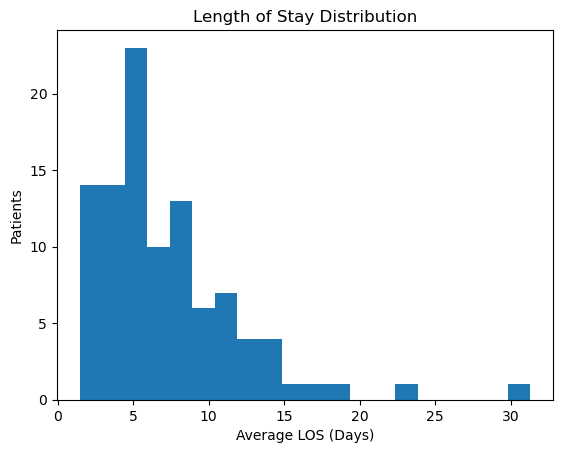

In [15]:
plt.hist(patient_df['avg_los_days'], bins=20)
plt.xlabel("Average LOS (Days)")
plt.ylabel("Patients")
plt.title("Length of Stay Distribution")
plt.show()

## ICU Utilization

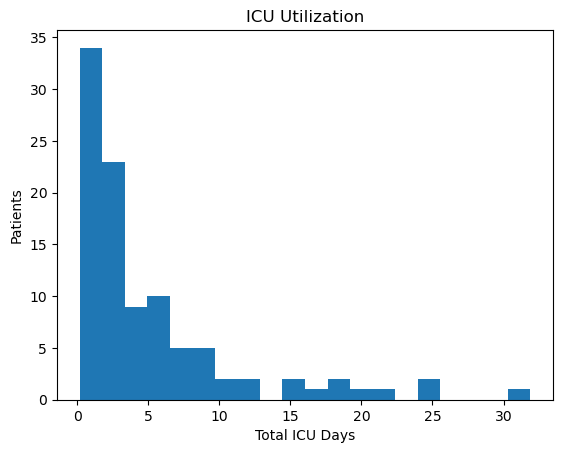

In [16]:
plt.hist(patient_df['total_icu_days'], bins=20)
plt.xlabel("Total ICU Days")
plt.ylabel("Patients")
plt.title("ICU Utilization")
plt.show()

## Segment Counts

In [17]:
patient_df['resource_segment'].value_counts()

resource_segment
Low       34
Medium    33
High      33
Name: count, dtype: int64

## Key Insights Table

In [18]:
patient_df.groupby('resource_segment').agg(
    avg_los=('avg_los_days', 'mean'),
    avg_icu_days=('total_icu_days', 'mean'),
    avg_transfers=('num_transfers', 'mean'),
    avg_diagnoses=('num_diagnoses', 'mean'),
    patients=('subject_id', 'count')
)


,avg_los,avg_icu_days,avg_transfers,avg_diagnoses,patients
resource_segment,,,,,
Low,4.676910,1.534156,4.911765,9.235294,34
Medium,7.176705,3.800536,8.363636,22.121212,33
High,9.840651,10.228305,22.636364,66.030303,33
